# Understand Robustness : Adult Census Income

----

In this notebook you'll explore the term of "$\text{Robustness}$" for a Machine Learning model. To go into specific we'll see that to have a robust model we need to get :

1. A model that is not overfitted or underfitted (bias-variance tradeoff)
2. A model that stays coherent when generating new data that are credible and outliers data
3. A model that resists to attack

This list allows us to go through some specific steps in a Machine Learning project :


| Section | Topics                            | Some references |
|---------|-----------------------------------|-----------------|
| 1.      | Cross validation                  |                 |
| 1.      | Train-Test (stratified) split     |                 |
| 1.      | Bias-Variance tradeoff            |                 |
| 2.      | Interpretability                  |                 |
| 2.      | Local explanation                 |                 |
| 2.      | Generating data to test the model |                 |
| 3.      | Differents attacks on a model     |                 |
| 3.      | Defending against these attacks   |                 |
    

For this notebook I choose to use [Adult Census Income dataset](https://www.kaggle.com/uciml/adult-census-income). It's available at the `../data/` directory.

## Import packages

In [2]:
import pandas as pd
import numpy as np

import os.path

from IPython.display import display, Markdown

## Load data

In [3]:
root_dir = '..'

In [4]:
fpath = os.path.join(root_dir, 'data/adult.csv')

data = pd.read_csv(fpath, na_values='?')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


The dataset is loaded ! Great. 

So now let's get a quick view of the data. I use [`pandas-profiling`](https://github.com/pandas-profiling/pandas-profiling) package to get a quick insight of the data.

## Analyse dataset

In [6]:
data.sample(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
23097,48,Private,125892,Bachelors,13,Divorced,Exec-managerial,Other-relative,White,Male,0,0,40,United-States,<=50K
2597,40,Private,284303,Some-college,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,7688,0,40,United-States,>50K
13751,28,NaN,167094,10th,6,Divorced,NaN,Not-in-family,White,Male,0,0,50,United-States,<=50K
20561,46,Private,353219,9th,5,Divorced,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
27858,44,Private,210648,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,>50K


In [7]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title="Adult Census Income", explorative=True)

In [8]:
fpath = os.path.join(root_dir, 'notebooks/reports/adult.html')

# profile.to_file(fpath)

In [9]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [10]:
Markdown('Report available at : [%s](%s)'%(fpath, fpath))

Report available at : [../notebooks/reports/adult.html](../notebooks/reports/adult.html)

Using this report we can see the following informations :

- There is 24 dupplicates rows
- `workclass` has 1836 (5.6%) missing values
- `occupation` has 1843 (5.7%) missing values 
- `native.country` has 583 (1.8%) missing values 
- `capital.gain` has 29849 (91.7%) zeros
- `capital.loss` has 31042 (95.3%) zeros 
- our target `income` is not correlated with `fnlwgt`, `race` and `native.country`
- `relationship` and `sex` are really correlated
- `education.num` is the encoded version of `education`

## Data Preparation

So we'll do the following preprocessing tasks :

- Drop duplicates rows
- Drop useless columns

And then for the next tasks we create a `scitkit-learn` pipeline to transform our data with the following steps :

- Missing values imputer : most common for categories and median for numeric
- OneHotEncoder for categories
- StandardScaler to finish

In [11]:
# drop duppl rows
data = data.drop_duplicates().reset_index(drop=True)

In [12]:
# drop useless columns
data = data.drop(columns=[
    'fnlwgt','race','native.country','education','relationship'
])

In [13]:
data.sample(5)

,age,workclass,education.num,marital.status,occupation,sex,capital.gain,capital.loss,hours.per.week,income
18392,45,Private,9,Divorced,Sales,Female,0,0,35,<=50K
20176,24,Private,9,Never-married,Adm-clerical,Male,0,0,40,<=50K
7908,20,Private,9,Never-married,Handlers-cleaners,Male,0,0,40,<=50K
27559,36,Local-gov,10,Separated,Adm-clerical,Male,0,0,40,<=50K
20525,36,Local-gov,13,Divorced,Prof-specialty,Female,0,0,60,<=50K


Before creating the pipeline let's encode our target `income` to 1 and 0.

In [14]:
target = 'income'

data[target] = data[target].replace({
    '<=50K':0,
    '>50K':1
})

In [15]:
data[target].value_counts()

0    24698
1     7839
Name: income, dtype: int64

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [17]:
numeric_features = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['workclass', 'marital.status', 'occupation', 'sex']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [18]:
preprocessor = preprocessor.fit(data)

In [19]:
data_preprocessed = preprocessor.transform(data)

In [20]:
pd.DataFrame.sparse.from_spmatrix(data_preprocessed).sample(5)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
26502,1.203602,-0.420679,-0.145975,-0.216743,-0.845597,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12122,0.030390,1.134777,-0.145975,-0.216743,1.584202,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24816,-0.482890,0.745913,-0.145975,-0.216743,-0.440630,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
20213,2.450140,-0.031815,-0.145975,-0.216743,-3.032416,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
29658,-0.556216,-0.420679,-0.145975,-0.216743,-0.035664,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# 1. Robustness : bias-variance tradeoff

If you're not familiar with a classic Machine Learning project pipeline, after defining your problem, collect and analyse your data you will need to choose some algorithms to train so that you'll get a model which can predict the task defined at first.

Like cooking, training a model need some basic ingredients :
- Reliable data : analysed to get the best insight from it and to be sure of its quality
- A sample to learn, a sample to validate and a sample to test
- An algorithm (or more) that is compatible with your task
- A metric (or more) to validate your trained model

**Let's assume that our data are reliable for the next part.**

The next question before starting the training to ask is the following : 

    "Is my dataset representative of the real world ?"

In most cases, training data is extracted from the same source as the future data on which the forecasts will be made. But, imagine you are training an AI that will be able to recognize traffic signs and you use only US traffic signs images, if in reality your algorithm is used in Europe the real data is different from training ! **You need to anticipate if your training data do not miss some possible input in real situation.**

Again for our Adult Census income case, let's say that the data is representative.

---

## 1.1. What is a train, validation and test set ?

Now how can we ensure our model is robust ?

Wikipedia says :

    In computer science, robustness is the ability of a computer system to cope with errors during execution 
    and cope with erroneous input.
    
<div style="text-align:right"><a target="_blank" href="https://en.wikipedia.org/wiki/Robustness_(computer_science)">Wikipedia : Robustness (computer science)</a></div>
    
For the Machine Learning, we can add that :

    The robustness is the property that characterizes how effective your algorithm is while being tested 
    on the new independent (but similar) dataset. In the other words, the robust algorithm is the one, 
    the testing error of which is close to the training error.
    

<div style="text-align:right"><a target="_blank" href="https://www.researchgate.net/post/What_is_the_definition_of_the_robustness_of_a_machine_learning_algorithm">ResearchGate : What is the definition of the robustness of a machine learning algorithm?</a></div>

And enter the term of **train set** and **test set** (and I add the **validation set**). What are they ?

- **Training Dataset**: The sample of data used to fit the model.
- **Validation Dataset**: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
- **Test Dataset**: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

[About Train, Validation and Test Sets in Machine Learning](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)

This picture summarize the concept :    

<br>
<br>

<img width="700" src="https://miro.medium.com/max/1896/1*r73p1rxMZWnZLoYi5Odf4A.png">

<br>
<br>

<strong style="color:red">/!\ You need to be sure each dataset are representative of the "real world" and randomly generated /!\ </strong> (some tasks don't need random generation like timeseries prediction)


## 1.2. Cross validation (K-fold)

In k-fold cross-validation, the original sample is randomly partitioned into $k$ equal sized subsamples. Of the $k$ subsamples, a single subsample is retained as the validation data for testing the model, and the remaining $k − 1$ subsamples are used as training data. The cross-validation process is then repeated $k$ times, with each of the $k$ subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling (see below) is that all observations are used for both training and validation, and each observation is used for validation exactly once.


<div style="text-align:right"><a target="_blank" href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation">Wikipedia : Cross Validation</a></div>



<br>
<br>

<img width="700" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/KfoldCV.gif/1920px-KfoldCV.gif">

Illustration of k-fold cross-validation when n = 12 observations and k = 3. After data is shuffled, a total of 3 models will be trained and tested.
<br>
<br>
<br>
<br>



## 1.3. How to split the dataset into train, validation and test ?

There is not magic frequency for the split of the training set. But if you have not a lot of data (1000~10000 rows) the rule of 60% train, 20% validation and 20% is recommended.

But when you have a lot of data like more than 10 millions, taking 1% as validation and test is more than acceptable.

Also it's important to know that when splitting randomly this sets, you can have some bias passed if the dataset is small. For this reason you can use stratified methods that split data with similar distributions for each features.



## 1.4. Overfitting & Underfitting

**Overfitting** is when your model is specialized on your training set : it works really well on your train set, but it do not generalize well. **When a model overfit, we say that the model has a high variance.**

What is variance?

    Variance is the variability of model prediction for a given data point or a value which tells us spread 
    of our data. Model with high variance pays a lot of attention to training data and does not 
    generalize on the data which it hasn’t seen before. As a result, such models perform very well 
    on training data but has high error rates on test data.
    
**Underfitting**  is the case where the model has “ not learned enough” from the training data, resulting in low generalization and unreliable predictions. **When a model underfit, we say that the model has a high bias.**

What is bias?

    Bias is the difference between the average prediction of our model and the correct value which 
    we are trying to predict. Model with high bias pays very little attention to the training data 
    and oversimplifies the model. It always leads to high error on training and test data.
    
[Understanding the Bias-Variance Tradeoff](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229)

<br>
<br>

<img src="https://miro.medium.com/max/700/1*9hPX9pAO3jqLrzt0IE3JzA.png">

Why is Bias Variance Tradeoff?

If our model is too simple and has very few parameters then it may have high bias and low variance. On the other hand if our model has large number of parameters then it’s going to have high variance and low bias. So we need to find the right/good balance without overfitting and underfitting the data.

This tradeoff in complexity is why there is a tradeoff between bias and variance. An algorithm can’t be more complex and less complex at the same time.

--- 

## In practice : on Adult Census Income

Here, I decided to train a **RandomForest** algorithm and to use **accuracy** as the score function.

<br>
<br>

### train_test_split

If your using tabular data, you can use the `train_test_split()` function from `scikit-learn`

[Documentation of train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Using this function allows you to separate train and test randomly.

In [21]:
from sklearn.model_selection import train_test_split

X = preprocessor.transform(data)
y = data[target]

# Spliting train and test set.
# Don't forget to specify a random_state to reproduce this operation in the future !
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
display(Markdown('X_train shape : %s'%str(X_train.shape)))
display(Markdown('X_test shape : %s'%str(X_test.shape)))

X_train shape : (26029, 36)

X_test shape : (6508, 36)

In [23]:
# Check target freq into train and test
print('y_train freq')
display(y_train.value_counts(normalize=True))
print('y_test freq')
display(y_test.value_counts(normalize=True))

y_train freq


0    0.757232
1    0.242768
Name: income, dtype: float64

y_test freq


0    0.766441
1    0.233559
Name: income, dtype: float64

### Statrified split with `StratifiedShuffleSplit`

To go further : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [69]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)

for train_index, test_index in stratified_split.split(X, y):
    data_train = data.iloc[train_index]
    data_test = data.iloc[test_index]
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Overfitting example

Let's create a Decision Tree that has a `max_depth` of 500 which means overfitting because it'll explore almost all possibilities of the train set.

In [25]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    max_depth=500,
    random_state=42
)

# Training the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=500, random_state=42)

In [26]:
from sklearn.metrics import accuracy_score

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy : %.2f%%'%(acc_train*100))
print('Test accuracy : %.2f%%'%(acc_test*100))

Train accuracy : 97.22%
Test accuracy : 81.50%


We can see the training score is fat better than the testing one.

**To be sure that your model is not overfitted you need to compare train and test score : if the difference is important then your model is overfitted**

### Underfitting example

In [27]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    max_depth=1,
    random_state=42
)

# Training the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1, random_state=42)

In [28]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy : %.2f%%'%(acc_train*100))
print('Test accuracy : %.2f%%'%(acc_test*100))

Train accuracy : 75.91%
Test accuracy : 75.91%


In this example the accuracy is very low for both the train set and the test set !


**To be sure that your model is not underfitted you need to compare train and test score : if both score are low then your model is underfitted**

### Cross validation with a grid search

The module `scikit-learn` offers you some ways to use cross validation. 

You can use the `GridSearchCV` which tests all combinations with a given list of parameters. Also there is the `RandomizedSearchCV` class that tests random combinations.

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators': [10,25,50,100],
    'max_depth': [2,5,7,10],
    'min_samples_split': [2,5,10]
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(rf, parameters)

grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 25, 50, 100]})

In [30]:
clf = grid.best_estimator_

In [31]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy : %.2f%%'%(acc_train*100))
print('Test accuracy : %.2f%%'%(acc_test*100))

Train accuracy : 86.95%
Test accuracy : 85.71%


In [32]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf)])

In [33]:
pipeline.predict_proba(data)

array([[0.87512694, 0.12487306],
       [0.77933399, 0.22066601],
       [0.79471151, 0.20528849],
       ...,
       [0.70998689, 0.29001311],
       [0.9525087 , 0.0474913 ],
       [0.99641018, 0.00358982]])

# 2. Robustness : reliability of the prediction on new data

In this section I will present the robustness of a model when you see how the model acts from a local perspective : it means not by comparing some metrics but by looking whether the model gives logic output with given an input and why it is given it.

For example, if you're training a model to recognizes wolves, and all the training picture contains snow, maybe your model will think "this is a wolf, because there is snow in the picture".

Here comes, the term of **Interpretability**. 

**In this part, I will mainly cite the (wonderfull) book of Christoph Molnar : [Interpretable Machine Learning
A Guide for Making Black Box Models Explainable.](https://christophm.github.io/interpretable-ml-book/)**. I really encourage you to read the full book to get a better understanding of this problem. Here you will have some insight and, I prefer to focus on code example.


## What is interpretability ?

There is no mathematical definition of interpretability. A (non-mathematical) definition I like by Miller (2017) is: Interpretability is the degree to which a human can understand the cause of a decision. Another one is: Interpretability is the degree to which a human can consistently predict the model's result. The higher the interpretability of a machine learning model, the easier it is for someone to comprehend why certain decisions or predictions have been made. A model is better interpretable than another model if its decisions are easier for a human to comprehend than decisions from the other model. I will use both the terms interpretable and explainable interchangeably. [Chapter 2](https://christophm.github.io/interpretable-ml-book/interpretability.html)

## Interpretable models

The easiest way to achieve interpretability is to use only a subset of algorithms that create interpretable models. Linear regression, logistic regression and the decision tree are commonly used interpretable models.

All interpretable models explained in this book are interpretable on a modular level, with the exception of the k-nearest neighbors method. The following table gives an overview of the interpretable model types and their properties. A model is linear if the association between features and target is modelled linearly. A model with monotonicity constraints ensures that the relationship between a feature and the target outcome always goes in the same direction over the entire range of the feature: An increase in the feature value either always leads to an increase or always to a decrease in the target outcome. Monotonicity is useful for the interpretation of a model because it makes it easier to understand a relationship. Some models can automatically include interactions between features to predict the target outcome. You can include interactions in any type of model by manually creating interaction features. Interactions can improve predictive performance, but too many or too complex interactions can hurt interpretability. Some models handle only regression, some only classification, and still others both.

From this table, you can select a suitable interpretable model for your task, either regression (regr) or classification (class):

| Algorithm |	Linear | 	Monotone |	Interaction |	Task | 
|  ---- | ---- | ---- | --- | ---- |
|Linear regression |	Yes |	Yes |	No |	regr |
|Logistic regression |	No |	Yes |	No |	class|
|Decision trees |	No |	Some |	Yes |	class,regr|
|RuleFit |	Yes 	|No |	Yes |	class,regr|
|Naive Bayes |	No |	Yes 	|No |	class|
|k-nearest neighbors |	No |	No |	No |	class,regr|

[Chapter 4 Interpretable Models](https://christophm.github.io/interpretable-ml-book/simple.html)

## How to explain a prediction ? (model-agnostic)

Separating the explanations from the machine learning model (= model-agnostic interpretation methods) has some advantages (Ribeiro, Singh, and Guestrin 2016). **The great advantage of model-agnostic interpretation methods over model-specific ones is their flexibility0.** Machine learning developers are free to use any machine learning model they like when the interpretation methods can be applied to any model. Anything that builds on an interpretation of a machine learning model, such as a graphic or user interface, also becomes independent of the underlying machine learning model. Typically, not just one, but many types of machine learning models are evaluated to solve a task, and when comparing models in terms of interpretability, it is easier to work with model-agnostic explanations, because the same method can be used for any type of model.

[Chapter 5 Model-Agnostic Methods](https://christophm.github.io/interpretable-ml-book/agnostic.html)


<img width="500" src="https://christophm.github.io/interpretable-ml-book/images/big-picture.png">

Today, in the data science community, there is a method that is mainly used : Shapley values with [Shap package](https://github.com/slundberg/shap/) (11K stars at the end of november 2020).

We'll see how to use it in the next practice section.


## Generating data to test the model

## (option) Outliers

---
 
### In practice : with Adult census income dataset

#### Shap package : how to understand a prediction

Using it on the `RandomForestClassifier`

In [34]:
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [96]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(clf)

You can find out more Explainer on the GitHub page : https://github.com/slundberg/shap

In [97]:
# Expected values
explainer.expected_value

array([0.75926006, 0.24073994])

Here the expected value is the frequency of the target : if we know nothing about the data it's the probability.

In [98]:
sample_to_understand = X_test[0,:].toarray()

In [99]:
# Compute the shap_values on the ²data on which you want to explain the model’s output.
shap_values = explainer.shap_values(sample_to_understand)

In [100]:
print('Probabilities of the prediction:')
print(clf.predict_proba(sample_to_understand))

print('Ouput:')
print(clf.predict(sample_to_understand))

Probabilities of the prediction:
[[0.83146585 0.16853415]]
Ouput:
[0]


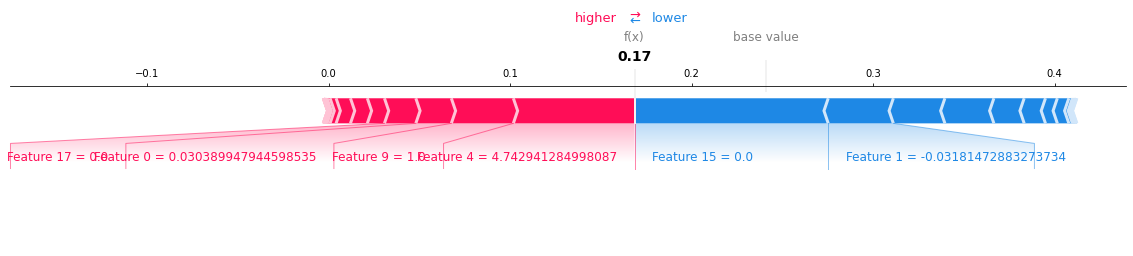

In [101]:
# Define the class to analyse
# Here 0 is <=50K and 1 is >50K
c = 1

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[c], shap_values[c], sample_to_understand, matplotlib=True)

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

**Using KernelExplainer to get categorical feature**

In [102]:
sample_to_understand = data.iloc[0,:].to_frame().T
sample_to_understand

,age,workclass,education.num,marital.status,occupation,sex,capital.gain,capital.loss,hours.per.week,income
0,90,NaN,9,Widowed,NaN,Female,0,4356,40,0


In [103]:
print('Probabilities of the prediction:')
print(pipeline.predict_proba(sample_to_understand))

print('Ouput:')
print(pipeline.predict(sample_to_understand))

Probabilities of the prediction:
[[0.87512694 0.12487306]]
Ouput:
[0]


In [104]:
# Creating a custom function for the explainer
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=data.columns)
    return pipeline.predict_proba(data_asframe)

# I passed some sample of the train data to gain some times
# But it's recommended to pass trained data
explainer = shap.KernelExplainer(model_predict, data=data_train.sample(100))#, link='logit')

In [105]:
explainer.expected_value

array([0.7343434, 0.2656566])

Expected values almost equal to the real ones.

In [106]:
# Compute the shap_values on the ²data on which you want to explain the model’s output.
shap_values = explainer.shap_values(sample_to_understand)

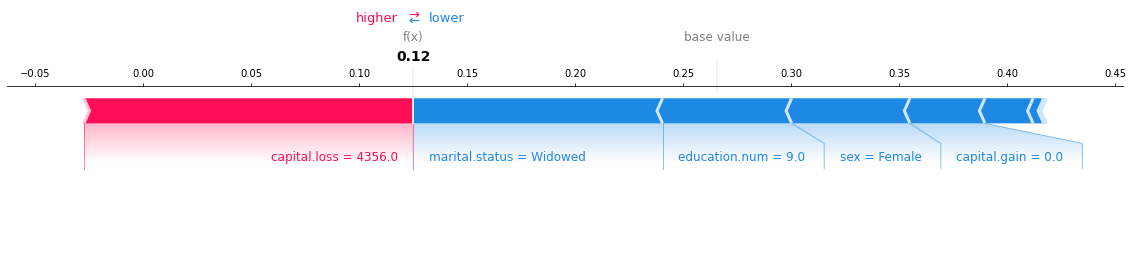

In [107]:
# Define the class to analyse
# Here 0 is <=50K and 1 is >50K
c = 1

shap.force_plot(
    explainer.expected_value[c],
    np.array(shap_values[c]), 
    sample_to_understand,
    matplotlib=True
)

Now we understand how the prediction was obtained.

We start at `23.68%` chance of being `>50K` and the fact that this person has a capital loss push the probability up but all the others informations are pushing the probability down. 

And if we look closely this explanation, we can ask ourself why `sex=Female` has this much importance so what happen if we change this information.

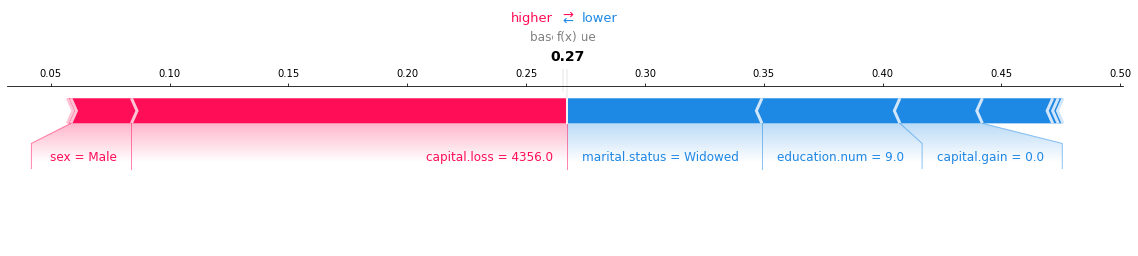

In [108]:
sample_to_understand.loc[:,'sex'] = 'Male'

shap_values = explainer.shap_values(sample_to_understand)

shap.force_plot(
    explainer.expected_value[c],
    np.array(shap_values[c]), 
    sample_to_understand,
    matplotlib=True
)

Now we see that the probability gained **15%**. 

And this is an practical exmaple of how to analyse a model behavior.

### In practice : test the model to common data

### In practice : test the model to outliers

# 3. Robustness : resistent to attacks